In [1]:
import matplotlib.pyplot as plt
import twodlearn as tdl
import twodlearn.tests.bayesnet_test
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

In [2]:
dataset = tdl.tests.bayesnet_test.create_heteroscedastic_dataset()

Data set created, shape:  (1000,)


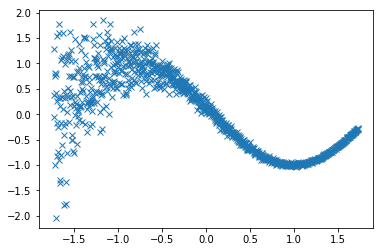

In [3]:
plt.plot(dataset.train.x, dataset.train.y, 'x')

In [4]:
@tdl.core.create_init_docstring
class SampleLayer(tdl.core.Layer):
    @tdl.core.InputArgument
    def input_shape(self, value):
        return value
    
    @tdl.core.InputModel
    def distribution(self, value):
        if value is None:
            raise tdl.core.exceptions.ArgumentNotProvided(self)
        return value
    
    @tdl.core.InputModel
    def sample_shape(self, value):
        if value is not None:
            value = tf.TensorShape(value)
        return value
    
    def call(self, inputs, *args, **kargs):
        tdl.core.assert_initialized(
            self, 'call', ['distribution', 'sample_shape'])
        distribution = (self.distribution(inputs) 
                        if callable(self.distribution)
                        else self.distribution)
        if self.sample_shape is not None:
            return distribution.sample(sample_shape=sample_shape)
        else:
            return distribution.sample()
    
    

@tdl.core.create_init_docstring
class NormalModel(tdl.core.TdlModelCallable):
    @tdl.core.InputArgument
    def batch_shape(self, value):
        if value is None:
            raise tdl.core.exceptions.ArgumentNotProvided(self)
        if not isinstance(value, tf.TensorShape):
            value = tf.TensorShape(value)
        return value
        
    @tdl.core.SubmodelInit
    def loc(self, initializer=None, trainable=True, **kargs):
        tdl.core.assert_initialized(self, 'loc', ['batch_shape'])
        if initializer is None:
            initializer = tf.keras.initializers.zeros()
        shape = tf.TensorShape(
            (1 if dim is None else dim) 
            for dim in self.batch_shape.as_list())
        return self.add_weight(
            name='loc',
            initializer=initializer,
            shape=shape,
            trainable=trainable,
            **kargs)
    
    @tdl.core.SubmodelInit
    def scale(self, initializer=None, trainable=True, **kargs):
        tdl.core.assert_initialized(self, 'shape', ['batch_shape'])
        shape = tf.TensorShape(
            (1 if dim is None else dim) 
            for dim in self.batch_shape.as_list())
        if initializer is None:
            initializer = tdl.constrained.PositiveVariableExp.init_wrapper(
                initializer=tf.keras.initializers.ones(),
                trainable=trainable,
                tolerance=1e-5,
                **kargs)            
        return initializer(shape=shape)
    
    def build(self, input_shape=None):
        tdl.core.assert_initialized(self, 'build', ['loc', 'scale'])
        self.built = True

    def call(self, inputs, *args, **kargs):
        if inputs is not None:
            inputs = tf.convert_to_tensor(inputs)
        loc = (self.loc(inputs) if callable(self.loc)
               else self.loc)
        scale = (self.scale(inputs) if callable(self.scale)
                 else self.scale)
        return tfp.distributions.Normal(loc=loc, scale=scale)
            
        
def homoscedastic():
    return NormalModel(
        batch_shape=[None, 1],
        loc=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=10, tolerance=1e-5),
                    tf.keras.activations.softplus,
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5)]))

def heteroscedastic():
    return NormalModel(
        batch_shape=[None, 1],
        loc=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=10, tolerance=1e-5),
                    tf.keras.layers.Activation(tf.nn.softplus),
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5)]),
        scale=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=5, tolerance=1e-5),
                    tf.keras.layers.Activation(tf.nn.softplus),
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5),
                    tf.keras.layers.Activation(tf.exp)])
    )


#model = homoscedastic()
model = heteroscedastic()
test_model = SampleLayer(distribution=model)

In [5]:
labels = tf.placeholder(tf.float32, (None, 1))
inputs = tf.placeholder(tf.float32, (None, 1))
output = model(inputs)
samples = test_model(inputs)

# loss
kernel_prior = tfp.distributions.Normal(loc=0.0, scale=1000.0)
kl = [tfp.distributions.kl_divergence(kernel, kernel_prior)
      for kernel in [model.loc.layers[0].kernel,
                     model.loc.layers[2].kernel]]
try:
    kernel_prior = tfp.distributions.Normal(loc=0.0, scale=100.0)
    kl.update([tfp.distributions.kl_divergence(kernel, kernel_prior)
      for kernel in [model.scale.layers[0].kernel,
                     model.scale.layers[2].kernel]])
except AttributeError:
    pass
loss = -tf.reduce_mean(tf.reduce_sum(output.log_prob(labels), -1),
                       0) \
       + (1/dataset.train.n_samples)*tf.add_n([tf.reduce_sum(kl_i) for kl_i in kl])


optim = tdl.optim.Optimizer(loss=loss, var_list=tdl.core.get_trainable(model),
                            log_folder='tmp/',
                            learning_rate=0.01)


In [6]:
tdl.core.initialize_variables(model)

In [7]:
optim.run(feed_train=
            lambda:{labels: dataset.train.y[..., np.newaxis],
                    inputs: dataset.train.x[..., np.newaxis]},
          n_train_steps=2000)

100 | [('train/loss', 1.6958461928367614)] | []
200 | [('train/loss', 1.0952410525083538)] | []
300 | [('train/loss', 0.9670818436145777)] | []
nan
checkpoint created
400 | [('train/loss', 0.924586033225059)] | []
500 | [('train/loss', 0.8990706348419184)] | []
600 | [('train/loss', 0.878691581487655)] | []
700 | [('train/loss', 0.8349611884355539)] | []
0.19428034820696383
checkpoint created
800 | [('train/loss', 0.3923992554098365)] | []
900 | [('train/loss', -0.28557159170508434)] | []
1000 | [('train/loss', -0.4863526956737046)] | []
1100 | [('train/loss', -0.6874340188503268)] | []
1200 | [('train/loss', -0.7055981469154361)] | []
0.3254402669564967
checkpoint created
1300 | [('train/loss', -0.7473067647218707)] | []
1400 | [('train/loss', -0.7595448642969135)] | []
1500 | [('train/loss', -0.7683541953563693)] | []
1600 | [('train/loss', -0.7747479844093326)] | []
0.016714501508115365
checkpoint created
1700 | [('train/loss', -0.7805963212251666)] | []
1800 | [('train/loss', -0.78

In [8]:
session = tf.get_default_session()
loc, scale = session.run([output.loc, output.scale], 
            feed_dict={inputs: dataset.train.x[..., np.newaxis]})

test_samples = session.run([samples], 
            feed_dict={inputs: dataset.train.x[..., np.newaxis]})

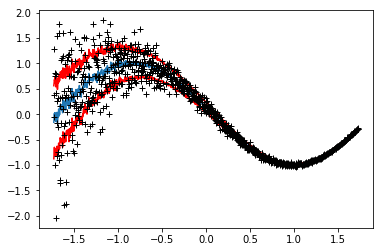

In [9]:
plt.plot(dataset.train.x, loc)
plt.plot(dataset.train.x, loc+scale, 'r')
plt.plot(dataset.train.x, loc-scale, 'r')
plt.plot(dataset.train.x, dataset.train.y, '+k')

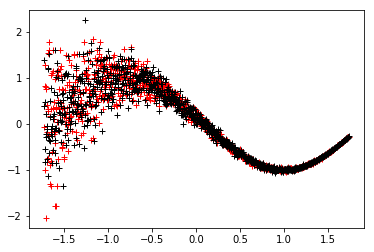

In [10]:
plt.plot(dataset.train.x, dataset.train.y, '+r')
plt.plot(dataset.train.x, np.squeeze(test_samples), '+k')

In [11]:
loss_value = loss.eval(
    feed_dict={labels: dataset.train.y[..., np.newaxis],
               inputs: dataset.train.x[..., np.newaxis]})
assert loss_value < -0.7, 'loss value higher than normal'
assert loss_value > -0.9, 'loss value lower than normal'